In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Versions of HDF5 earlier than 1.8.13 seem to give trouble
import h5py
print h5py.version.info

Summary of the h5py configuration
---------------------------------

h5py    2.5.0
HDF5    1.8.14
Python  2.7.10 (default, Sep 24 2015, 00:07:46) 
[GCC 4.4.5 20110214 (Red Hat 4.4.5-6)]
sys.platform    linux2
sys.maxsize     9223372036854775807
numpy   1.10.1



In [3]:
sys.path.insert(0, '../src')

import timedomainwaveform as tdwave
import timedomainrom as tdrom
import eobtrainingset as eob
import greedy
import empiricalinterpolation as eim
import diagnostics as diagnostics
import chebyshev as cheb

import imp
imp.reload(tdwave)
imp.reload(tdrom)
imp.reload(eob)
imp.reload(greedy)
imp.reload(eim)
imp.reload(diagnostics)
imp.reload(cheb)

<module 'chebyshev' from '../src/chebyshev.pyc'>

# Get training set

In [11]:
training_set_dir = '../data/home/bdlackey/teob/teob_runs_cheb16_f10_v2'
ts_filename = '../data/teob_runs_cheb16_f10_v2_%d.hdf5'
# break up hdf5 file into 16GB chunks
memb_size=2**34-1
param_names = ['q', 'LambdaA', 'LambdaB']
samples_per_cycle = 20
ts = eob.get_eob_training_set(training_set_dir, ts_filename, memb_size=memb_size, regular_grid=True, 
                              param_names=param_names, samples_per_cycle=samples_per_cycle)
ts.close()

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000


In [4]:
ts_filename = '../data/teob_runs_cheb16_f10_v2_%d.hdf5'
memb_size=2**34-1
ts = tdwave.load_hdf5_time_domain_waveform_set(ts_filename, memb_size=memb_size)

# Test training set

[  5.00000000e-01   5.00000000e+01   4.78602501e+03]


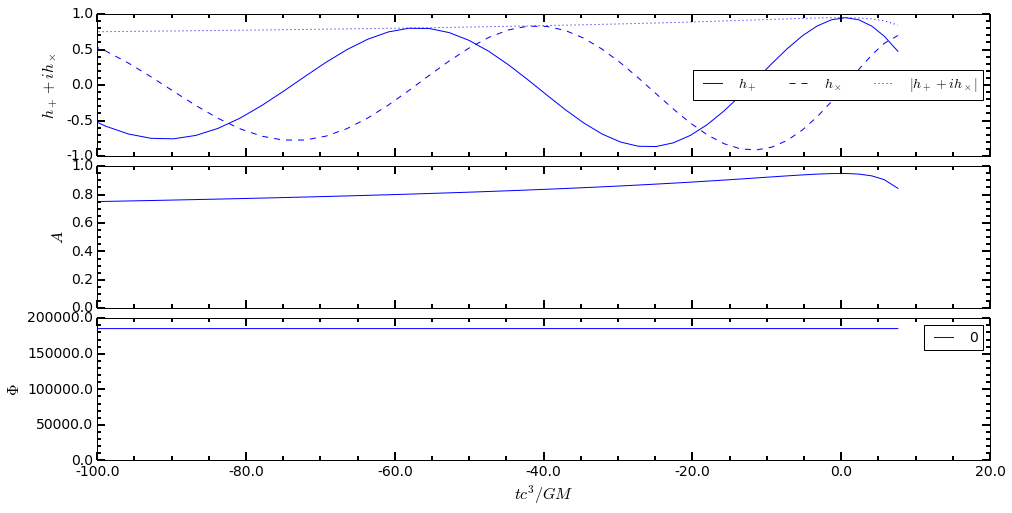

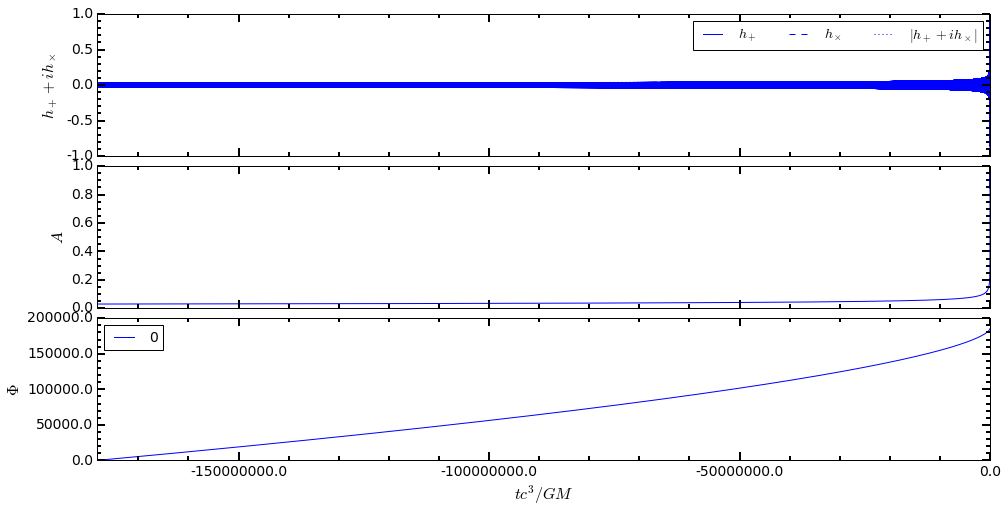

In [5]:
i=13
waveforms = ts.get_waveform_data(i)
print ts.get_waveform_data(i, data='parameters')

xlim=[-100, 20]
fig = plt.figure(figsize=(16, 8))
tdwave.plot_time_domain_waveform_list(fig, waveforms, imag=True, mag=True, 
                               xlim=xlim, xlabel=r'$tc^3/GM$',
                               ylabel_pol=r'$h_+ + i h_\times$', 
                               ylabel_amp=r'$A$', ylabel_phase=r'$\Phi$', 
                               pol_legend=True)

xlim=[waveforms.time[0], waveforms.time[-1]]
fig = plt.figure(figsize=(16, 8))
tdwave.plot_time_domain_waveform_list(fig, waveforms, imag=True, mag=True, 
                               xlim=xlim, xlabel=r'$tc^3/GM$',
                               ylabel_pol=r'$h_+ + i h_\times$', 
                               ylabel_amp=r'$A$', ylabel_phase=r'$\Phi$', 
                               pol_legend=True)

(-50, 10)

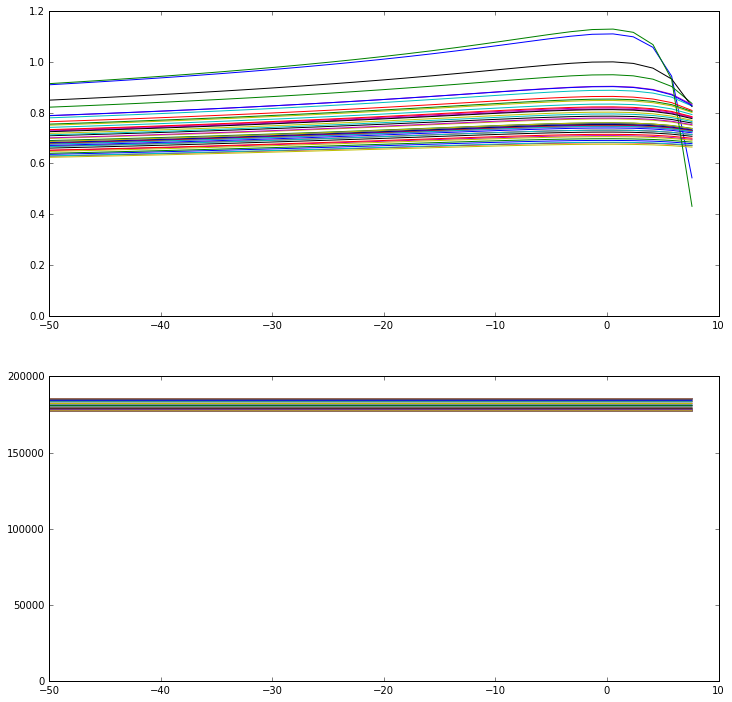

In [8]:
fig = plt.figure(figsize=(12, 12))

axes = fig.add_subplot(211)
for i in range(0, ts.get_len(), 100):
    axes.plot(ts.get_waveform_data(i).time, ts.get_waveform_data(i).amp, marker='')
axes.set_xlim([-50, 10])

axes = fig.add_subplot(212)
for i in range(0, ts.get_len(), 100):
    axes.plot(ts.get_waveform_data(i).time, ts.get_waveform_data(i).phase, marker='')
axes.set_xlim([-50, 10])
#axes.set_ylim([170000, 190000])
#axes.set_ylim([ts.get_waveform_data(0).phase[-1]-400, ts.get_waveform_data(0).phase[-1]+200])

# Make reduced basis

### Greedy algorithm for amplitude

In [20]:
epsilon = 1.0e-12

# Initialize the ReducedBasis object
add = tdwave.add_amp
subtract = tdwave.subtract_amp
scalar_multiply = tdwave.scalar_multiply_amp
inner_product = tdwave.inner_product_amp_simps
#inner_product = tdwave.inner_product_amp
get_waveform = ts.get_waveform_data
ts_params = ts.get_parameters()
rbamprun = greedy.ReducedBasis(add, subtract, scalar_multiply, inner_product, get_waveform, ts_params)

# Standard method
rbamprun.generate_reduced_basis(epsilon, ts_istart=0, Nbases=None)

1.0
0.000105437297602
2.23420448109e-06
7.49566605118e-07
1.0083767954e-07
5.82845738339e-09
1.76083680969e-09
7.0042349698e-10
7.73640040919e-11
1.33814070935e-11
4.93494134446e-12
5.77649039712e-13


In [21]:
# Store reduced basis in HDF5TimeDomainWaveformSet object
filename = '../data/teob_rbamp_smallq_cheb_16_%d.hdf5'
param_names = ['q', 'LambdaA', 'LambdaB']
rbamp = tdwave.HDF5TimeDomainWaveformSet(filename, mode='x', memb_size=memb_size)
#rbamp = tdwave.HDF5TimeDomainWaveformSet(filename)
rbamp.set_parameter_names(param_names)
rbamp.set_grid_shape(shape=None)
rbamp.add_waveform_list(rbamprun.rb, rbamprun.rb_params)
rbamp.close()

/home/bdlackey/virtenvs/python-notebook/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


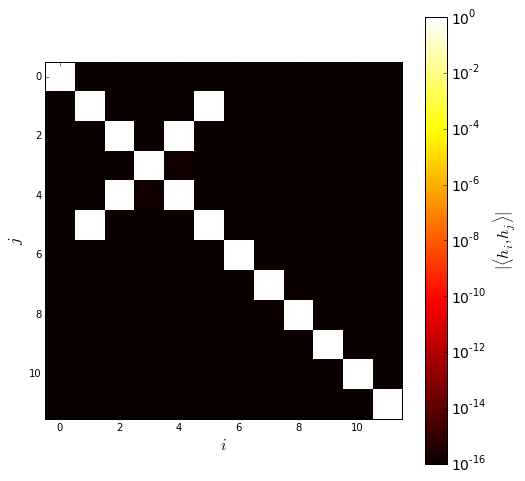

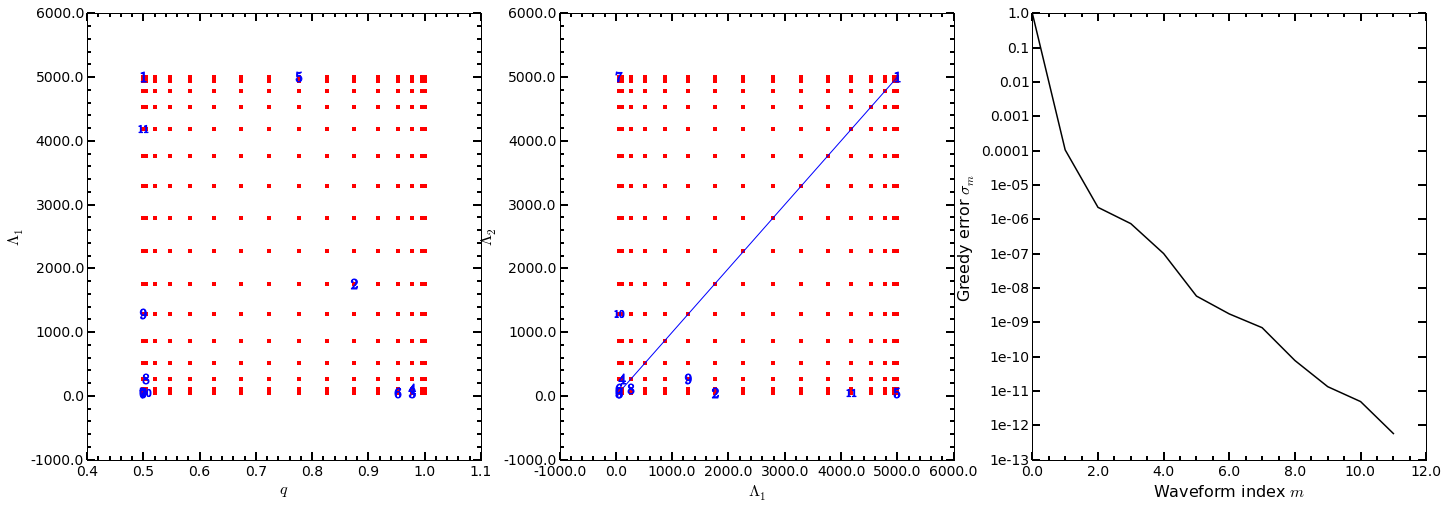

In [22]:
inner = diagnostics.check_orthonormality(rbamprun.rb, inner_product)

fig = plt.figure(figsize=(24, 8))

axes = fig.add_subplot(131)
diagnostics.plot_parameters(axes, 0, 1, ts_params=rbamprun.ts_params, rb_params=rbamprun.rb_params, 
                xlabel=r'$q$', ylabel=r'$\Lambda_1$')

axes = fig.add_subplot(132)
diagnostics.plot_parameters(axes, 1, 2, ts_params=rbamprun.ts_params, rb_params=rbamprun.rb_params, 
                xlabel=r'$\Lambda_1$', ylabel=r'$\Lambda_2$')
axes.plot([0, 5000], [0, 5000])

axes = fig.add_subplot(133)
diagnostics.plot_greedy_error(axes, rbamprun.sigma_list)

### Greedy algorithm for phase

In [23]:
epsilon = 1.0e-12

# Initialize the ReducedBasis object
add = tdwave.add_phase
subtract = tdwave.subtract_phase
scalar_multiply = tdwave.scalar_multiply_phase
inner_product = tdwave.inner_product_phase_simps
#inner_product = tdwave.inner_product_phase
get_waveform = ts.get_waveform_data
ts_params = ts.get_parameters()
rbphaserun = greedy.ReducedBasis(add, subtract, scalar_multiply, inner_product, get_waveform, ts_params)

# Standard method
rbphaserun.generate_reduced_basis(epsilon, ts_istart=0, Nbases=None)

1.0
5.13589171192e-10
6.06013017546e-11
4.18554080284e-14


In [24]:
# Store reduced basis in HDF5TimeDomainWaveformSet object
filename = '../data/teob_rbphase_smallq_cheb_16_%d.hdf5'
param_names = ['q', 'LambdaA', 'LambdaB']
rbphase = tdwave.HDF5TimeDomainWaveformSet(filename, mode='x', memb_size=memb_size)
rbphase.set_parameter_names(param_names)
rbphase.set_grid_shape(shape=None)
rbphase.add_waveform_list(rbphaserun.rb, rbphaserun.rb_params)
rbphase.close()

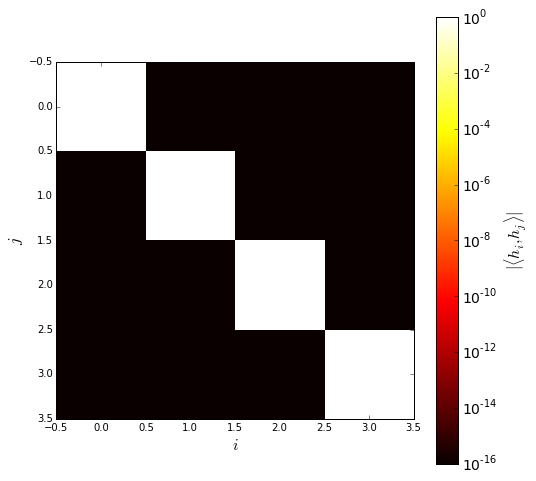

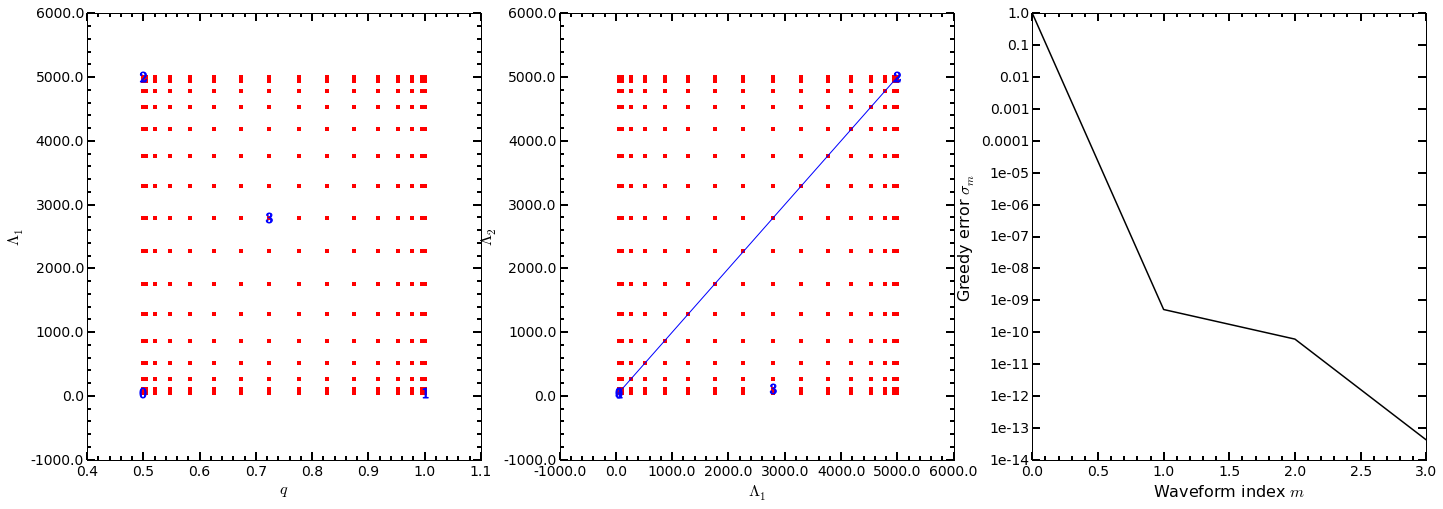

In [25]:
inner = diagnostics.check_orthonormality(rbphaserun.rb, inner_product)

fig = plt.figure(figsize=(24, 8))

axes = fig.add_subplot(131)
diagnostics.plot_parameters(axes, 0, 1, ts_params=rbphaserun.ts_params, rb_params=rbphaserun.rb_params, 
                xlabel=r'$q$', ylabel=r'$\Lambda_1$')

axes = fig.add_subplot(132)
diagnostics.plot_parameters(axes, 1, 2, ts_params=rbphaserun.ts_params, rb_params=rbphaserun.rb_params, 
                xlabel=r'$\Lambda_1$', ylabel=r'$\Lambda_2$')
axes.plot([0, 5000], [0, 5000])

axes = fig.add_subplot(133)
diagnostics.plot_greedy_error(axes, rbphaserun.sigma_list)

# Generate empirical nodes

In [9]:
memb_size=2**34-1

filename = '../data/teob_rbamp_smallq_cheb_16_%d.hdf5'
rbamp = tdwave.load_hdf5_time_domain_waveform_set(filename, memb_size=memb_size)

filename = '../data/teob_rbphase_smallq_cheb_16_%d.hdf5'
rbphase = tdwave.load_hdf5_time_domain_waveform_set(filename, memb_size=memb_size)

In [10]:
empirical_node_indices_amp, Bamp_j = tdrom.empirical_interpolation_for_time_domain_waveform(rbamp, 'amp')
empirical_node_indices_phase, Bphase_j = tdrom.empirical_interpolation_for_time_domain_waveform(rbphase, 'phase')

In [11]:
# Store interpolating functions in HDF5TimeDomainWaveformSet object

# Amplitude
memb_size=2**26-1
filename = '../data/Bamp_%d.hdf5'
Bamp = tdwave.HDF5TimeDomainWaveformSet(filename, mode='x', memb_size=memb_size)
Bamp.set_grid_shape(shape=None)
Bamp.set_parameter_names(['q', 'LambdaA', 'LambdaB'])
Bamp.add_waveform_list(Bamp_j, [[0.0, 0.0, 0.0]]*len(Bamp_j))
Bamp.close()

# Phase
filename = '../data/Bphase_%d.hdf5'
Bphase = tdwave.HDF5TimeDomainWaveformSet(filename, mode='x', memb_size=memb_size)
Bphase.set_grid_shape(shape=None)
Bphase.set_parameter_names(['q', 'LambdaA', 'LambdaB'])
Bphase.add_waveform_list(Bphase_j, [[0.0, 0.0, 0.0]]*len(Bphase_j))
Bphase.close()

In [12]:
memb_size=2**26-1

filename = '../data/Bamp_%d.hdf5'
Bamp = tdwave.load_hdf5_time_domain_waveform_set(filename, memb_size=memb_size)

filename = '../data/Bphase_%d.hdf5'
Bphase = tdwave.load_hdf5_time_domain_waveform_set(filename, memb_size=memb_size)

In [13]:
Bamp_list = [Bamp.get_waveform_data(i) for i in range(Bamp.get_len())]
Bphase_list = [Bphase.get_waveform_data(i) for i in range(Bphase.get_len())]

In [14]:
Bamp.close()
Bphase.close()

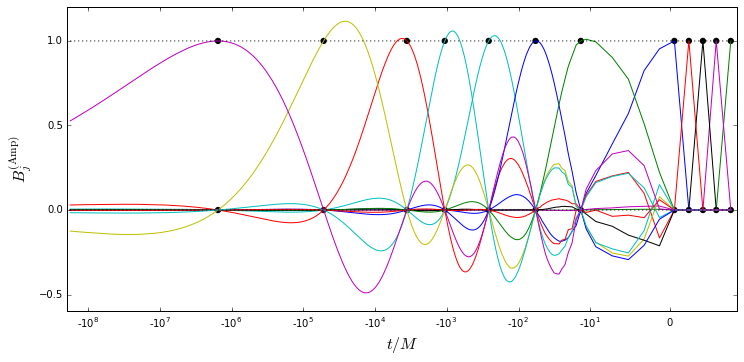

In [15]:
fig = plt.figure(figsize=(12, 12))
axes = fig.add_subplot(211)

for j in range(len(Bamp_j)):
    #for j in range(4):
    h = Bamp_j[j]
    axes.plot(h.time, h.amp)

axes.plot(h.time, 0*h.time, ls=':', c='k')
axes.plot(h.time, 0*h.time+1, ls=':', c='k')
axes.set_xlim([1.1*h.time[0], 1.1*h.time[-1]])
#axes.set_ylim([-1.5, 1.5])
axes.set_xscale('symlog', linthreshx=10.0)
#axes.set_yscale('symlog', linthreshy=0.1)

indices = empirical_node_indices_amp
htime = h.time[indices]
#hamp = h.amp[indices]
#axes.scatter(htime, hamp, marker='o', c='r')
axes.scatter(htime, 0*htime, marker='o', c='k', s=40, edgecolor='none')
axes.scatter(htime, 0*htime+1, marker='o', c='k', s=40, edgecolor='none')

axes.set_xlabel(r'$t/M$', fontsize=16)
axes.set_ylabel(r'$B^{\rm (Amp)}_j$', fontsize=16)
# axes.set_xticklabels(axes.get_xticks(), fontsize=14)
# axes.set_yticklabels(axes.get_yticks(), fontsize=14)
# axes.minorticks_on()
# axes.tick_params(which='major', width=2, length=8)
# axes.tick_params(which='minor', width=2, length=4)

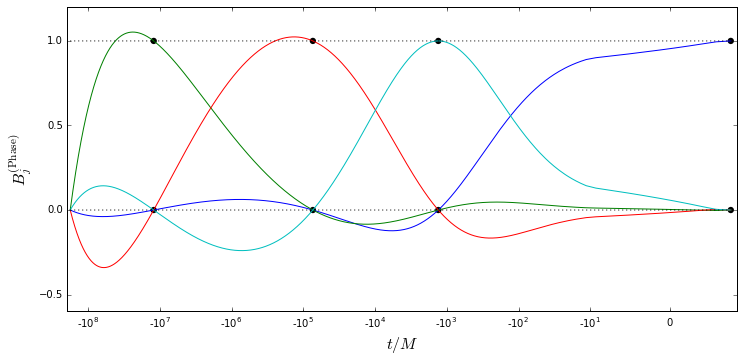

In [16]:
fig = plt.figure(figsize=(12, 12))
axes = fig.add_subplot(211)

for j in range(len(Bphase_j)):
    #for j in range(4):
    h = Bphase_j[j]
    axes.plot(h.time, h.phase)

axes.plot(h.time, 0*h.time, ls=':', c='k')
axes.plot(h.time, 0*h.time+1, ls=':', c='k')
axes.set_xlim([1.1*h.time[0], 1.1*h.time[-1]])
#axes.set_ylim([-1.5, 1.5])
axes.set_xscale('symlog', linthreshx=10.0)
#axes.set_yscale('symlog', linthreshy=0.1)

indices = empirical_node_indices_phase
htime = h.time[indices]
#hamp = h.phase[indices]
#axes.scatter(htime, hphase, marker='o', c='r')
axes.scatter(htime, 0*htime, marker='o', c='k', s=40, edgecolor='none')
axes.scatter(htime, 0*htime+1, marker='o', c='k', s=40, edgecolor='none')

axes.set_xlabel(r'$t/M$', fontsize=16)
axes.set_ylabel(r'$B^{\rm (Phase)}_j$', fontsize=16)
# axes.set_xticklabels(axes.get_xticks(), fontsize=14)
# axes.set_yticklabels(axes.get_yticks(), fontsize=14)
# axes.minorticks_on()
# axes.tick_params(which='major', width=2, length=8)
# axes.tick_params(which='minor', width=2, length=4)

# Interpolate training set amp and phase at empirical nodes

In [22]:
# This extracts each training set waveform from the HD, so it will take several minutes.
train_amp_at_nodes = tdrom.waveform_data_at_empirical_nodes(ts, empirical_node_indices_amp, 'amp')
train_phase_at_nodes = tdrom.waveform_data_at_empirical_nodes(ts, empirical_node_indices_phase, 'phase')

KeyboardInterrupt: 

In [18]:
param_grid = ts.get_parameter_grid()

# Turn amp-at-empirical-nodes to list-of-grids
shape = tuple(ts.grid_shape)
Nnodes = len(train_amp_at_nodes[0])
train_amp_grid_list = []
for i in range(Nnodes):
    amp_grid = train_amp_at_nodes[:, i].reshape(shape)
    train_amp_grid_list.append(amp_grid)
    
# Turn amp-at-empirical-nodes to list-of-grids
shape = tuple(ts.grid_shape)
Nnodes = len(train_phase_at_nodes[0])
train_phase_grid_list = []
for i in range(Nnodes):
    phase_grid = train_phase_at_nodes[:, i].reshape(shape)
    train_phase_grid_list.append(phase_grid)

In [19]:
params_min = param_grid[0, 0, 0]
params_max = param_grid[-1, -1, -1]
amp_coeff_list = cheb.chebyshev_coefficient3d_list_generator(train_amp_grid_list, params_min, params_max)
phase_coeff_list = cheb.chebyshev_coefficient3d_list_generator(train_phase_grid_list, params_min, params_max)

In [20]:
print len(amp_coeff_list), amp_coeff_list[0].shape
print len(phase_coeff_list), phase_coeff_list[0].shape

12 (16, 16, 16)
4 (16, 16, 16)


In [21]:
filename = '../data/amp_coeffs.hdf5'
coefficients_list = amp_coeff_list
cheb.save_chebyshev_coefficients_list(filename, coefficients_list, params_min, params_max)

filename = '../data/phase_coeffs.hdf5'
coefficients_list = phase_coeff_list
cheb.save_chebyshev_coefficients_list(filename, coefficients_list, params_min, params_max)

# Load ROM

In [23]:
memb_size=2**26-1
Bamp_filename = '../data/Bamp_%d.hdf5'
Bphase_filename = '../data/Bphase_%d.hdf5'
ampcoeff_filename = '../data/amp_coeffs.hdf5'
phasecoeff_filename = '../data/phase_coeffs.hdf5'
rom = tdrom.load_reduced_order_model_time_domain_waveform(Bamp_filename, Bphase_filename, memb_size,
                                                  ampcoeff_filename, phasecoeff_filename)

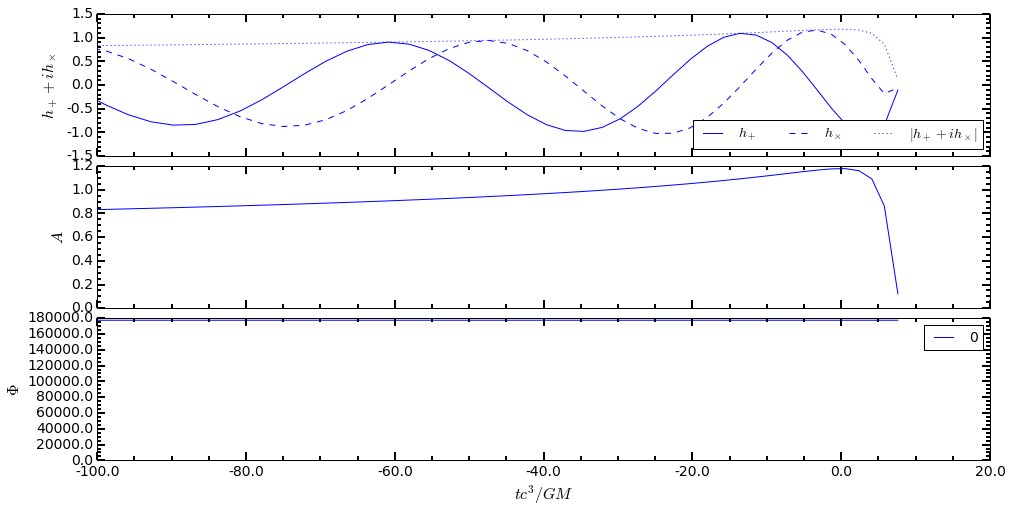

In [24]:
params = [1.0, 50.0, 50.0]
waveforms = rom.evaluate(params)

xlim=[-100, 20]
fig = plt.figure(figsize=(16, 8))
tdwave.plot_time_domain_waveform_list(fig, waveforms, imag=True, mag=True, 
                               xlim=xlim, xlabel=r'$tc^3/GM$',
                               ylabel_pol=r'$h_+ + i h_\times$', 
                               ylabel_amp=r'$A$', ylabel_phase=r'$\Phi$', 
                               pol_legend=True)